All the imports needed for the running of the script, Updated as the experemnt goes 

In [2]:
import pandas as pd 
import numpy as np 
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
from datetime import datetime, timedelta
from functools import reduce
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
warnings.filterwarnings('ignore')
import progressbar
import tensorflow as ts
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers,models
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.linear_model import LogisticRegression
from random import random

Data preprocessing. This converts a timestamp in the format %M:%S%S.%f%f Where 
- %M is Minutes with no padded zeros 
- %S is Seconds with zeros padded to the left
- %f is Milliseconds with no padded zeros 

To milliseconds. 

In [3]:
def memory_gbts(unit) : 
    local_unit = 0.0
    if unit.endswith("K"):
        local_unit = float(unit[:-1])/1e9
    elif unit.endswith("M"): 
        local_unit = float(unit[:-1])/1e6
    elif unit.endswith("G") : 
        local_unit = float(unit[:-1])/1e3
    else : 
        local_unit = float(unit)/1e12
    return local_unit

In [4]:
def memory_converter(memory) :
    memory_over_terabyte = []
    for unit in memory :
        local_unit = memory_gbts(unit)
            #print(unit)
        memory_over_terabyte.append(local_unit)
    return memory_over_terabyte

In [5]:
def time_converter(timestamp):
    broken_time = timestamp.split(".")
    milliseconds = float("0." + broken_time[-1]) * 1000
    borken_farther = broken_time[0].split(":")
    seconds = int(borken_farther[-1])
    minutes = int(borken_farther[0])
    total_seconds = seconds + minutes*60
    total_milliseconds = milliseconds + total_seconds*1000
    return total_milliseconds

This function extracts the time at which the file was logged from the file name and returns it as a timestamp 

In [6]:
def get_timestamp(filename) : 
    timestamp = filename[8:-4].replace('_',':')
    return timestamp

The following cell defines the column names for the read text files for when they are converted to a data frame

In [7]:
column_names = ["Process ID","User","PR","NI","VIRT","RES","SHR","S","[%CPU]","[%MEM]","TIME+","Args","Timestamp","Benign"]

This function will go through all files in any given directory and count how many are there. This is only used for updating the progressbar and is not nessesary for understanding the training process

In [8]:
def get_files_count(root,counter = 0):
    counter += 1
    for root, dirs, files in os.walk(root, topdown=True):
        for name in files:
            if name.endswith(".txt") : 
                counter += 1
        for name in dirs:
            new_path = os.path.join(root, name)
            counter = get_files_count(new_path,counter)
    return counter 

In [9]:
file_count = get_files_count(".")
counter = 0
bar = progressbar.ProgressBar(maxval=100, \
widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

In [10]:
def progressbar_ignite():
    global counter,bar
    counter = 0
    bar.start()

In [11]:
def progressbar_stop():
    global bar
    bar.update(100)
    bar.finish()

In [12]:
def update_progressbar(counter) : 
    global file_count,bar
    percent_done = counter/float(file_count)
    percent = int(percent_done*100)
    bar.update(percent)

Few cells for nicely presented output

In [13]:
def nice_graph_init(ylabel = "process count", xlabel = "Probability", title = r"Likelyhood of a process being benign",figsize = (8,6)): 
    plt.style.use('dark_background')
    figure = plt.figure(figsize = figsize)
    figure.subplots_adjust(bottom = 0.22)
    ax = figure.add_subplot(111)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_title(title, fontsize = 16, fontfamily = "monospace")
    ax.set_ylabel(ylabel, fontsize = 14, fontfamily = "monospace")
    ax.set_xlabel(xlabel, fontsize = 14, fontfamily = "monospace")
    ax.minorticks_on()
    return ax,figure

In [14]:
def nice_graph_finish(figure,ax,filename = "plot.png"):
    ax.xaxis.set_tick_params(length = 5, width = 1)
    ax.yaxis.set_tick_params(length = 5, width = 1)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

This cell makes sure the data is in the correct format

In [15]:
def turn_to_X(df) : 
    X = df.values
    X = np.asarray(X).astype('float32')
    return X

In [16]:
def list_to_array(data):
    df = pd.DataFrame(data,columns = column_names)
    X = df.drop(["Process ID","User","PR","NI","S","Args","Timestamp","Benign"],axis =1,inplace=False)
    X = turn_to_X(X)
    Y = df["Benign"].values
    Y = np.reshape(Y, (len(Y),1))
    return X,Y

In [17]:
def y_edit(y,N,tracker):
    prev_i = 0
    itters = 0
    ys = np.zeros((y.shape[0] - N*len(tracker),1))
    for num in tracker :
        ys[prev_i - N*itters : num - N*(itters+1)] = y[prev_i : num - N]
        itters += 1
        prev_i = num
    return ys

In [18]:
def rows_to_cells(rows, N,tracker) : 
    rows = np.array(rows)
    cells = np.zeros((rows.shape[0] - N*len(tracker),N,6))
    prev_i = 0
    itter = 0
    for num in tracker :
        for i in range(prev_i,num - N) :
            cells[i - N*itter,:,:] = rows[i:i+N,:]
        prev_i = num
        itter += 1
    return cells




In [19]:
def concatinate(full,new) : 
    return np.concatenate((full,new), axis = 0)

In [20]:
def read_enhanced(filename,safe_filename,all_data, benign = 1) : 
    # Reads a text file with columns seperated by tabs and stores it in a data frame object
    df = pd.read_csv(filename, delimiter = "\t", skiprows = [0,1,2,3,4,5,-1])
    # Stores the data contained in the data frame object in an array 
    data = df.iloc[:,0].values
    i = 0
    # Loop through all the data points 
    for d in data[:-1] :
        try :
            row = []
            # The variable d at this point is a whole line, with some awckward spacing between the different 
            # variables, so here all spaces are removed by the split method, then are rejoined with a single 
            # space beteween them by the use of the join method
            d = " ".join(d.split())
            # Storing all the data up to the 12th element in row, the 12th and beyond element needs further processing 
            row = d.split(" ")[:11]
            # Storing all the elements including and beyond the 12th element. They are saved all as a single variable
            # this variable is the API caller. 
            row.append(d.split(" ")[11:])
            # converting the PID (process ID) column to Integer
            row[0] = int(row[0])
            # Convert the memory information to numarical values 
            row[4:7] = memory_converter(row[4:7])
            row[9] = float(row[9])
            row[8] = float(row[8])
            # Convert timestamps into millisecond values 
            row[10] = time_converter(row[10])
            # Collect the sampling time from the filename 
            row.append(get_timestamp(safe_filename))
            # Indicate whether this row corrospond to a benign or a melign run 
            row.append(benign)
            # The row is done being processed and is stored
            if(np.sum(row[4:7]) > 0) :
                all_data.append(row)
            i += 1
        # For lines which might contain contaminated or corrupt data or data in different format
        except ValueError : 
            #print(safe_filename, " In the line " , i)
            #print(d)
            continue
    return all_data

This function will call [read_enhanced] for each file but then it will slice the data it gets into cells then concatinating them back into one grand list by using the two methods above. 

In [21]:
def CNN_Read(root,benign) :
    global tracker,all_data,tracker,counter,global_X,global_Y,N
    # Updating the progressbar everytime this function is called, this is a recursive function so it will be called
    # Multiple times 
    update_progressbar(counter)
    # Using the walk method which returns the root of the directory we are accessing, the child directories and 
    # the child files. Those are stored in root, dirs and files respectively
    for root, dirs, files in os.walk(root, topdown=True):
        # Looping through all the child files 
        for name in files:
            # Checking if they are text files, if so, then we are going to read them and store the values they have
            if name.endswith(".txt") : 
                try :
                    if(random() > 0.0) : 
                        file_path = os.path.join(root, name)
                        # Reading the file's contents and storing it in the list
                        all_data = read_enhanced(file_path,name,all_data,benign=benign)
                        tracker.append(len(all_data))
                        # We read one more file :) . (for the progressbar) 
                    counter += 1
                except ValueError : 
                    print("The current dimensions of Y global is : " , global_Y.shape)
                    print("The current dimensions of Y locaal is : " , loc_y.shape)
        # For each of the child directories we will check         
        for name in dirs:
            # If the directory name is Benign then all the following directories and files will be Benign files 
            # So we update the benign variable to 1 in the recursive call 
            new_path = os.path.join(root, name)
            if name == "Benign" :
                CNN_Read(new_path,1)
            # If the directory name is Malign then all the directories we will acess next and files will represent 
            # Malign data, so the benign variable is updated to 0. 
            elif name == "Malign" :
                
                CNN_Read(new_path,0)
            # If its neither, then this means we are accessing a folder within those previous two, it will contain 
            # data of the kind its parent directory have passed to it, 0 for Malign and 1 for benign 
            else : 
                CNN_Read(new_path,benign)

# Eperiment III 

### Data processing 

In [22]:
N = 100 # Number of rows to consider at a time
tracker = [] # Keeps track of where files end (At which row)
all_data = [] 
global_X = np.zeros((0,N,6)) # An array that will hold the final input
global_Y = np.zeros((0,1)) # An array that will hold the final output
progressbar_ignite() 
CNN_Read(".",1) # This will store all the data in all_data list
loc_x, loc_y = list_to_array(all_data) # Turning an array into 
progressbar_stop()

[=========================================================================] 100%


In [23]:
global_X = rows_to_cells(loc_x,N,tracker) # Remove data that don't fit 
global_Y = y_edit(loc_y,N,tracker) 
global_X = np.reshape(global_X,(-1,N,6,1))
X_train,X_test,Y_train,Y_test = train_test_split(global_X,global_Y, test_size = 0.2, random_state = 0)

### Training hyperparameters 

In [24]:
epoches = 50
batch_size = 4098*8
verbos = 1

### Model 

In [38]:
CNN = models.Sequential([layers.Conv2D(24,(3,3),activation="relu",input_shape=(N,6,1)),
                         layers.Conv2D(16,(4,4),activation="relu"),
                         layers.Flatten(),
                         layers.Dense(32,activation = "relu"),
                         layers.Dense(24,activation = "relu"),
                         layers.Dense(12,activation = "tanh"),
                         layers.Dense(1,activation="sigmoid")
])
Adam = ts.keras.optimizers.Adam(
    learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07
)
CNN.compile(optimizer=Adam,
              loss = "MeanSquaredError",
              metrics=['accuracy'])
CNN.fit(X_train, Y_train, batch_size=batch_size, epochs=epoches, verbose=verbos,
    validation_split=0.2, shuffle=True, validation_freq=1,
    max_queue_size=10, workers=4, use_multiprocessing=True)

Epoch 1/50
38/38 [==============================] - 341s 9s/step - loss: 0.2560 - accuracy: 0.5011 - val_loss: 0.2503 - val_accuracy: 0.5037
Epoch 2/50
38/38 [==============================] - 285s 7s/step - loss: 0.2501 - accuracy: 0.5042 - val_loss: 0.2501 - val_accuracy: 0.5039
Epoch 3/50
38/38 [==============================] - 280s 7s/step - loss: 0.2503 - accuracy: 0.5036 - val_loss: 0.2507 - val_accuracy: 0.5019
Epoch 4/50
38/38 [==============================] - 281s 7s/step - loss: 0.2502 - accuracy: 0.5022 - val_loss: 0.2501 - val_accuracy: 0.5023
Epoch 5/50
38/38 [==============================] - 308s 8s/step - loss: 0.2500 - accuracy: 0.5036 - val_loss: 0.2500 - val_accuracy: 0.5038
Epoch 6/50
38/38 [==============================] - 297s 8s/step - loss: 0.2500 - accuracy: 0.5040 - val_loss: 0.2500 - val_accuracy: 0.5039
Epoch 7/50
38/38 [==============================] - 284s 7s/step - loss: 0.2500 - accuracy: 0.5042 - val_loss: 0.2500 - val_accuracy: 0.5039
Epoch 8/50
38

KeyboardInterrupt: 

### Evaluation on test set 

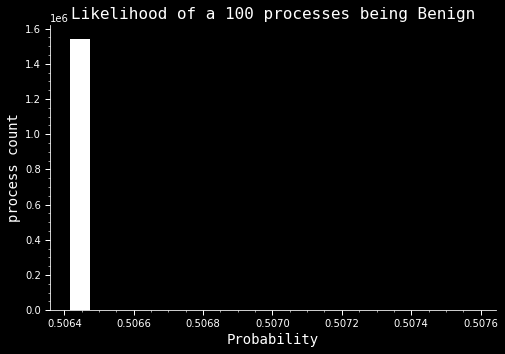

In [39]:
y_pred = CNN.predict(X_test)
ax, fig = nice_graph_init(title = "Likelihood of a " + str(N) + " processes being Benign")
plt.hist(y_pred,bins = 20,color = "white")
nice_graph_finish(fig,ax,filename = "CNNFinal.png")

# Experiment IV

### Data processing

In [25]:
global_X = np.reshape(global_X,(-1,N,6)) # Reshape the already acquired data since LSTM takes a 2D input
X_train,X_test,Y_train,Y_test = train_test_split(global_X,global_Y, test_size = 0.2, random_state = 0)

### Training hyperparameters 

In [30]:
epoches = 50
batch_size = 4098*8
verbos = 1

### Model 

In [31]:
RNN = models.Sequential([
                         layers.Bidirectional(layers.LSTM(20, activation = "relu", return_sequences=True),input_shape=(N,6)),
                        
                         layers.Bidirectional(layers.LSTM(20, activation = "relu")),
                         layers.Dense(32,activation = "relu"),
                         layers.Dense(24,activation = "relu"),
                         layers.Dense(12,activation = "tanh"),
                         layers.Dense(1,activation="sigmoid")
                        ])
RNN.compile(optimizer="adam",
              loss = "BinaryCrossentropy",
              metrics=['accuracy'])
RNN.fit(X_train, Y_train, batch_size=batch_size, epochs=epoches, verbose=verbos,
    validation_split=0.2, shuffle=True, validation_freq=1,
    max_queue_size=10, workers=4, use_multiprocessing=True)

Epoch 1/50
151/151 [==============================] - 56031s 373s/step - loss: 0.7195 - accuracy: 0.4993 - val_loss: 0.6998 - val_accuracy: 0.4991
Epoch 2/50
 47/151 [========>.....................] - ETA: 15:31 - loss: 0.7020 - accuracy: 0.4978

KeyboardInterrupt: 

### Evaluation on test set 

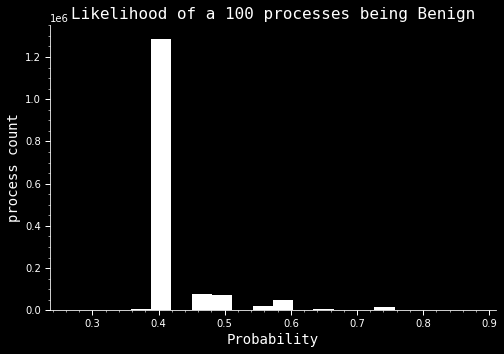

In [32]:
y_pred = RNN.predict(X_test)
ax, fig = nice_graph_init(title = "Likelihood of a " + str(N) + " processes being Benign")
plt.hist(y_pred,bins = 20,color = "white")
nice_graph_finish(fig,ax,filename = "RNNFinal.png")